In [31]:
using DataFrames, CSV
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Plots, StatsPlots, GRUtils
using Distributions
using Gurobi, JuMP

In [32]:
# Data
data = Matrix(DataFrame(CSV.File("../data/demand.csv")));

# Constants
N = round(Int, (size(data)[1] - 2) / 2)    # number of trips
K = 5 ;                                    # number of shuttles

# Splitting the data into sublists
q = data[1:2*N+2, 4];
d = data[1:2*N+2, 5];
e = data[1:2*N+2, 7];
l = data[1:2*N+2, 8];

#### The cost matrix

We need to compute the cost matrix t[i,j]. For the moment, we know the cost matrix t[i,j] where i and j are origin-destination pairs. As a recall, we have selected 19 possible origins and 45 possible destinations. As our model here includes 99 trips, our current formulation gives: t[i,j] could be t[67,97] which of course leads to an error. Therefore, we should find a way to compute the cost matrix t[i,j] for each trip.

In [36]:
data[200,:]

9-element Vector{Any}:
    0
   42.36381606868144
  -71.0885840857672
    0
    0.0
    0.0
    0.0
 1000.0
     "Depot"

In [37]:
2*N+2

200

In [38]:
driving_times
findfirst()

,Name,Kendall Square T,Wadsworth at Amherst,Media Lab,Media Lab at Ames
,String31,Float64,Float64,Float64,Float64
1,Baker House,7.6167,7.7833,8.5167,8.35
2,Burton Conner,8.0167,8.1833,8.9167,8.7667
3,East Campus,1.85,1.85,0.6,0.7667
4,MacGregor House,7.9667,8.1333,8.8667,8.7
5,Maseeh Hall,3.9333,3.2333,3.9667,4.2
6,McCormick Hall,4.5333,3.8333,4.5667,4.8
7,New House,5.3667,6.4333,6.05,6.1167
8,Next House,4.8833,5.95,5.5667,5.6333
9,New Vassar,4.8667,5.9167,5.5167,5.5833


In [44]:
data

200×9 Matrix{Any}:
  0  42.3638  -71.0886   0  …  "Depot"
  1  42.3599  -71.102    1     "Sidney-Pacific"
  2  42.3599  -71.102    1     "Sidney-Pacific"
  3  42.3575  -71.0945   1     "McCormick Hall"
  4  42.3592  -71.0976   1     "New Vassar"
  5  42.3621  -71.0854   1  …  "Graduate Tower"
  6  42.3551  -71.1032   1     "Westgate Apartments"
  7  42.3601  -71.087    1     "70 Amherst Street"
  8  42.3561  -71.0979   1     "Burton Conner"
  9  42.3601  -71.098    1     "Edgerton House"
 10  42.3575  -71.0945   2  …  "McCormick Hall"
 11  42.3556  -71.0996   1     "MacGregor House"
 12  42.3561  -71.0979   1     "Burton Conner"
  ⋮                         ⋱  
 89  42.3549  -71.1025  -1     "Tang/Westgate"
 90  42.3558  -71.0995  -2     "Burton/MacGregor"
 91  42.3601  -71.087   -1  …  "70 Amherst Street"
 92  42.3585  -71.094   -1     "MIT Chapel"
 93  42.362   -71.0983  -1     "Random Hall"
 94  42.3611  -71.0846  -1     "Wadsworth at Amherst"
 95  42.3613  -71.0866  -1     "MIT Medi

In [42]:
findfirst(driving_times[:, 1] .== "MIT Medical Urgent Care Service")

In [41]:
# Use this cost later to load costs from BingsMap. For now, we will simply use the euclidian distance as shown below.
driving_times = DataFrame(CSV.File("../data/origin_destination_times.csv"))
# c = Matrix(DataFrame(CSV.File("../data/origin_destination_times.csv")))
# c = c[:, 2:size(c)[2]]

# Let's construct the matrix t[i,j]
t = zeros(2*N+2, 2*N+2)
for i in 1:2*N+2
    for j in 1:2*N+2
        orr = data[i,9]
        des = data[j,9]
        println(orr)
        idx = findfirst(driving_times[:, 1] .== orr)
        t[i,j] = driving_times[idx, des]
    end 
end 

c = t ; #let's consider in this initial model that the travel cost and the time and equivalent. 

Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depot
Depo

LoadError: MethodError: no method matching getindex(::DataFrame, ::Nothing, ::String31)
[0mClosest candidates are:
[0m  getindex(::DataFrame, [91m::typeof(!)[39m, ::Union{AbstractString, Symbol}) at ~/.julia/packages/DataFrames/zqFGs/src/dataframe/dataframe.jl:524
[0m  getindex(::DataFrame, [91m::Colon[39m, ::Union{AbstractString, Signed, Symbol, Unsigned}) at ~/.julia/packages/DataFrames/zqFGs/src/dataframe/dataframe.jl:510
[0m  getindex(::DataFrame, [91m::InvertedIndex[39m, ::Union{AbstractString, Signed, Symbol, Unsigned}) at ~/.julia/packages/DataFrames/zqFGs/src/dataframe/dataframe.jl:506
[0m  ...

In [ ]:
t

100×100 Matrix{Float64}:
 0.0     2.3     2.3     4.4667  5.6333  …  5.8333  6.2167  1.2833  5.8
 2.4333  0.0     0.0     4.4333  2.9667     5.7167  6.1833  2.0667  5.7667
 2.4333  0.0     0.0     4.4333  2.9667     5.7167  6.1833  2.0667  5.7667
 5.25    5.0333  5.0333  0.0     6.4167     5.1833  1.6833  3.7667  1.7167
 4.4167  1.6833  1.6833  4.5667  0.0        5.85    6.3167  3.4     5.9
 7.4667  7.25    7.25    4.0667  8.6333  …  3.4333  4.5833  5.9833  4.2167
 5.5     5.2833  5.2833  4.0167  6.6667     5.55    5.7667  4.0     5.3667
 6.1833  5.7333  5.7333  3.1333  7.1167     0.9333  3.65    5.1     3.2833
 8.2333  7.15    7.15    7.4833  8.5667     9.0167  9.2333  7.4667  0.0
 3.2167  1.2333  1.2333  2.9     2.6333     4.1833  4.65    1.7333  4.2333
 5.25    5.0333  5.0333  0.0     6.4167  …  5.1833  1.6833  3.7667  1.7167
 8.1667  7.1     7.1     7.4333  8.5        8.9667  9.1667  7.4167  8.7833
 8.2333  7.15    7.15    7.4833  8.5667     9.0167  9.2333  7.4667  0.0
 ⋮          

### The model

In [ ]:
model = Model(Gurobi.Optimizer)

V =  1:2*N+2                    # all vertices
P = 2:N+1                       # pick up vertices
D = N+2:2*N+1                   # drop off vertices
PUD = 2:2*N+1                   # all pick up and drop off vertices together (all vertices except depot)

T = fill(1000, K)                # maximum duration of route k
L = 1000                         # maximum time of a drive
Q = fill(3, K)                # capacity of each car

# Variables
@variable(model, x[1:2*N+2, 1:2*N+2, 1:K] >= 0, Bin)   # x[i, j, k] = 1 if we go from node i to node j with vehicle k.
@variable(model, w[1:2*N+2, 1:K] >= 0, Int)            # w[i,k] load of vehicle k when arriving upon leaving vertex i
@variable(model, r[1:N] >= 0)                          # r[i,k] travel time of passenger i (Note that passenger i is identified by) the vertex i+1

@variable(model, u[1:2*N+2, 1:K] >= 0)                 # u[i,k] time as which the vertex i is served by vehicle k

#############  Constraints  #############

# only one car can bring passenger {i, i+N} to its final destination.
@constraint(model, [i in P], sum(sum(x[i, j, k] for j in V) for k = 1:K) == 1)

# each vehicle starts at the depot
@constraint(model, [k = 1:K], sum(x[1, j, k] for j in V) == 1)

# each vehicle ends at the depot
@constraint(model, [k = 1:K], sum(x[i, 2*N+2, k] for i in V) == 1)

# each passenger is picked and droped by the same car
@constraint(model, [i in P, k = 1:K], sum(x[i, j, k] for j in V) - sum(x[i+N, j, k] for j in V) == 0)

# vehicle k follows the edges sequentially
@constraint(model, [i in PUD, k = 1:K], sum(x[j, i, k] for j in V) - sum(x[i, j, k] for j in V) == 0)

# PREVIOUS the time served of vertex i
@constraint(model, [i in V, j in V, k = 1:K], u[j, k] >= (u[i, k] + d[i] + t[i, j]) * x[i, j, k])

# updating the load of the vehicle
@constraint(model, [i in V, j in V, k = 1:K], w[j, k] >= (w[i, k] + q[j]) * x[i, j, k])

# updating the travel time of passenger i
@constraint(model, [i in P, k = 1:K], r[i-1] == u[N+i, k] - (u[i, k] + d[i]))

# respecting the total length of a trip
@constraint(model, [k = 1:K], u[2*N+2,k] - u[1,k] >= 0) # NEW
@constraint(model, [k = 1:K], u[2*N+2,k] - u[1,k] <= T[k])

# respecting travel window of passenger i
@constraint(model, [i in V, k = 1:K], e[i] <= u[i,k])
@constraint(model, [i in V, k = 1:K], u[i,k] <= l[i])

# respecting travel window of passenger i
@constraint(model, [i in P], t[i,i+N] <= r[i-1])
@constraint(model, [i in P], r[i-1] <= L)

# respecting each car's capacity
@constraint(model, [i in V, k = 1:K], max(0, q[i]) <= w[i, k])
@constraint(model, [i in V, k = 1:K], w[i, k] <= min(Q[k], Q[k] + q[i]))

# objective
@objective(model, Min, sum(sum(sum(c[i, j] * x[i, j, k] for k = 1:K) for i in V) for j in V));

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17


LoadError: BoundsError: attempt to access 99×99 Matrix{Float64} at index [100, 1]

In [ ]:
optimize!(model)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 627 rows, 2209 columns and 6893 nonzeros
Model fingerprint: 0x34d64d86
Model has 4000 quadratic constraints
Variable types: 109 continuous, 2100 integer (2000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [5e-01, 1e+01]
  Objective range  [1e-01, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+03]
Presolve added 1202 rows and 0 columns
Presolve removed 0 rows and 825 columns
Presolve time: 0.03s
Presolved: 2189 rows, 1564 columns, 16075 nonzeros
Variable types: 124 continuous, 1440 integer (1175 binary)

Root relaxation: objective 4.816670e+01, 455 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node

In [ ]:
u_values = value.(u)

20×5 Matrix{Float64}:
 174.21     76.2082    0.0       0.0      70.0582
 149.977   159.977   154.743   149.977   149.977
  95.359    95.359    95.359    95.359    92.5676
 133.999   131.514   131.514   131.514   131.514
 107.805   107.805    98.8423   97.805    97.805
  93.8589   93.8589   90.159    90.159    90.159
 132.98    124.661   132.98    124.661   124.661
 118.378   110.978   110.978   118.378   118.378
 151.112   151.112   151.112   142.196   151.112
  80.1082   80.1082   80.1082   88.9249   80.1082
 155.46    165.46    160.227   155.46    155.46
 122.618   122.618   122.618   122.618   119.826
 141.764   139.278   139.278   139.278   139.278
 129.23    129.23    120.268   119.23    119.23
  96.0756   96.0756   92.3757   92.3757   92.3757
 144.761   136.442   144.761   136.442   136.442
 120.778   113.378   113.378   120.778   120.778
 164.613   164.613   164.613   155.696   164.613
  85.1082   85.1082   85.1082   93.9249   85.1082
 279.113   243.928   290.419   930.276    73

In [ ]:
r_values = value.(r)

9-element Vector{Float64}:
  4.9833
 26.75857420820701
  7.264168652126415
 20.925274208207128
  1.7167
 11.280768652126367
  1.9
 13.000100000000003
  4.5

In [ ]:
w_values = round.(Int, value.(w))

20×5 Matrix{Int64}:
 0  0  0  0  0
 1  3  1  1  1
 1  3  1  1  1
 3  1  1  1  1
 3  3  2  1  1
 3  3  1  1  1
 3  3  2  1  1
 1  1  1  1  3
 1  1  1  1  3
 1  1  1  1  1
 0  0  0  0  2
 2  0  0  0  2
 2  0  1  0  0
 2  0  1  0  0
 0  2  0  0  0
 0  0  0  0  0
 0  0  2  0  2
 0  0  0  0  0
 0  0  0  0  0
 0  3  0  0  0

In [ ]:
function plot_route(df, x_val, w_val, plot_size)
    
    # df: dataframe containing all the input data:
    #     column 1: Passenger ID
    #     column 2: PickUp/DropOff Pos_x
    #     column 3: PickUp/DropOff Pos_y
    #     column 4: load (number of passengers to embark)
    #     column 5: service duration (embark time)
    #     column 6: preferred pick up time
    #     column 7: lower bound of pick up time
    #     column 8: upper bound of pick up time

    # car_nbr: the vehicle number to plot

    # x_val: the values of x
    
    #constants 
    N = round(Int,(size(df)[1]-2)/2)

    cars_used = findall([sum(x_val[:,:,i]) for i=1:size(x_val)[3]] .> 2)
    print(cars_used)
    
    println("Number of cars used: $(sum(cars_used))")
    println("The car(s) used are(is): ", cars_used)


    # plot the depot
    Plots.scatter([df[1, 2]], [df[2*N+2, 3]], 
        size = (plot_size[1], plot_size[2]),
        titlefont=font(20, "Computer Modern"), 
        color="black", 
        markersize=5, 
        labels="Depot", 
        title="Result for different cars",  
        legend = :outertopleft,
        format=:png)

    # plot all pick-up points
    for i=2:N+1
        pass_ID = round(Integer, df[i,1])

        Plots.scatter!([df[i, 2]], [df[i, 3]],
            color="lightgreen", 
            xlabel="x", ylabel="y",
            labels="PickUp ID: $pass_ID - $(data[i,4]) passenger(s)",  
            annotations = (df[i, 2], df[i, 3], Plots.text("  Pick:$pass_ID", :left, pointsize=10)),
            format=:png,
            markersize=5)

        Plots.scatter!([df[i+N, 2]], [df[i+N, 3]],
            color="red", 
            xlabel="x", ylabel="y",
            labels="DropOff ID: $pass_ID - $(data[i,4]) passenger(s)",  
            annotations = (df[i+N, 2], df[i+N, 3], Plots.text("  Drop:$pass_ID", :left, pointsize=10)),
            format=:png,
            markersize=5)
    end

    colors = ["black", "red", "green", "blue", "pink"]
    for car in cars_used
        vals = findall(x_val[:, :, car] .== 1)
        print(vals)
        for elem in vals
            i,j = elem[1], elem[2]
            print(i, " ", j, " --> ")
            Plots.plot!([df[i, 2], df[j, 2]], [df[i, 3], df[j, 3]], color=colors[car], labels="", textposition="bottom left", linewidth=1, arrow=true, arrowwidth=3, format=:png)
        end
        
        # for i in 1:2*N+2
        #     for j in 1:2*N+2
        #         if x_val[i, j, car] == 1
        #             print(i, " ", j, " --> ")
        #             Plots.plot!([df[i, 2], df[j, 2]], [df[i, 3], df[j, 3]], color=colors[car], labels="", textposition="bottom left", linewidth=1, arrow=true, arrowwidth=3, format=:png)
        #         end
        #     end
        # end
    end

    # plot the depot
    Plots.scatter!([df[1, 2]], [df[2*N+2, 3]], 
        titlefont=font(20, "Computer Modern"), 
        color="black", 
        markersize=5, 
        labels="Depot", 
        format=:png)

end


plot_route (generic function with 1 method)

[2, 3]Number of cars used: 5
The car(s) used are(is): [2, 3]
CartesianIndex{2}[CartesianIndex(19, 8), CartesianIndex(17, 9), CartesianIndex(1, 10), CartesianIndex(8, 17), CartesianIndex(9, 18), CartesianIndex(10, 19), CartesianIndex(18, 20)]19 8 --> 17 9 --> 1 10 --> 8 17 --> 9 18 --> 10 19 --> 18 20 --> CartesianIndex{2}[CartesianIndex(16, 2), CartesianIndex(15, 3), CartesianIndex(12, 4), CartesianIndex(3, 5), CartesianIndex(1, 6), CartesianIndex(4, 7), CartesianIndex(2, 11), CartesianIndex(14, 12), CartesianIndex(7, 13), CartesianIndex(5, 14), CartesianIndex(6, 15), CartesianIndex(13, 16), CartesianIndex(11, 20)]16 2 --> 15 3 --> 12 4 --> 3 5 --> 1 6 --> 4 7 --> 2 11 --> 14 12 --> 7 13 --> 5 14 --> 6 15 --> 13 16 --> 11 20 --> 

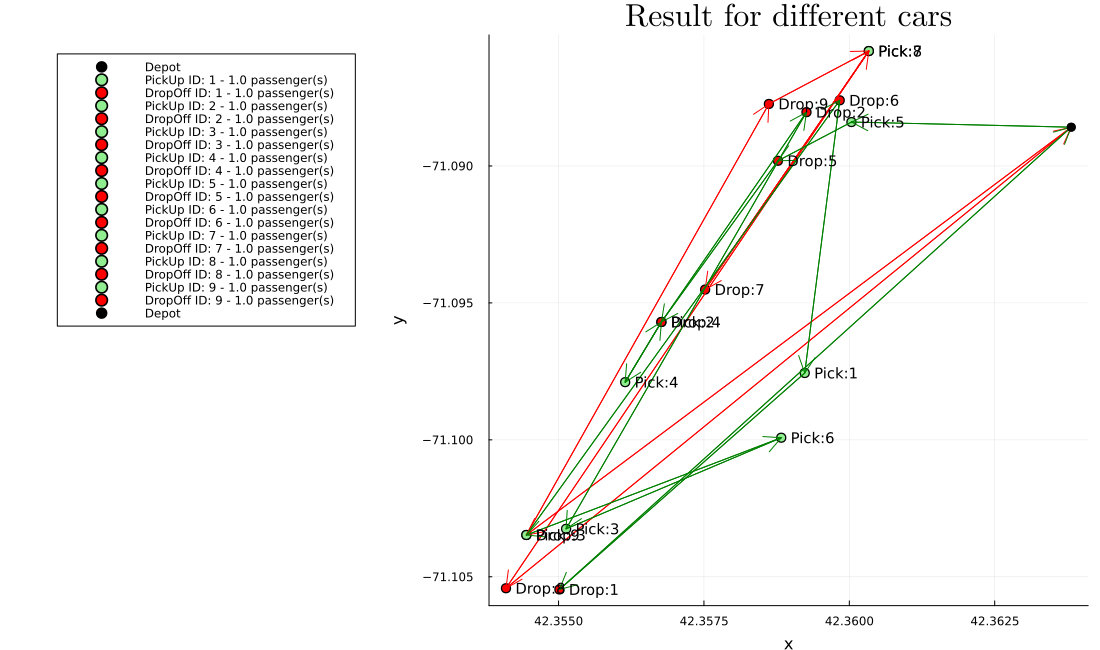

In [ ]:
x_values = round.(Int, value.(x))
w_values = round.(Int, value.(w))

plot_route(data, x_values, w_values, [1100, 650])